# KG-Hub: Advanced Knowledge Graph Assembly

This notebook serves as a practical guide to advanced KG-Hub features and resources. A brief review of the Getting Started tutorial notebook is not a strict prerequisite but may be helpful.  

This notebook also assumes you are in a Linux environment, but Google Colab is an option as well.

Here's an example question for our use case: which foods may impact DNA repair pathways? It's a broad question with many possible answers, or no answers at all. A KG may hold some clues. We don't want to be entirely reliant on existing data, however: starting with sets of chemicals, foods, and biological pathways, we can perform link prediction to predict additional connections.

## Setup

First, we'll install the requirements.


In [1]:
!pip install kgx
!pip install kghub-downloader

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kg-obo 0.1 requires kgx==1.5.1, but you have kgx 1.5.7 which is incompatible.
You should consider upgrading via the '/home/harry/kg-env/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/home/harry/kg-env/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import yaml

Now we need to set up two things for KGX to work properly:
* A download config file
* A merge config file

In practice, we may need to write a new transform for each new source, but all of the sources we'll use here are conveniently already available as KGX node and edge files on KG-Hub.

We'll download five sources. Two are ontologies available through the KG-OBO project on KG-Hub: FOODON, a food ontology, and CHEBI, a chemical ontology. The other sources are sets of preprocessed [Reactome](https://reactome.org) pathways, connections between those pathways, and mappings between those pathways and chemicals. They're all defined in a dictionary below, with the name of each source as its key and a list of one or more source URLs as its value. We've also defined a set of local filenames, as we know what the compressed ontology files should contain.

In [ ]:
data_dir = "./" # Just the current directory, though in practice it would be something like data/raw/
sources = {"foodon":["https://kg-hub.berkeleybop.io/kg-obo/foodon/2022-02-01/foodon_kgx_tsv.tar.gz"],
           "chebi":["https://kg-hub.berkeleybop.io/kg-obo/chebi/210/chebi_kgx_tsv.tar.gz"],
           "chebi2reactome":["https://kg-hub.berkeleybop.io/kg-idg/20220601/transformed/reactome/chebi2reactome_edges.tsv",
                             "https://kg-hub.berkeleybop.io/kg-idg/20220601/transformed/reactome/chebi2reactome_nodes.tsv"],
           "reactome_pathways":["https://kg-hub.berkeleybop.io/kg-idg/20220601/transformed/reactome/reactomepathways_nodes.tsv"],
           "reactome_relations":["https://kg-hub.berkeleybop.io/kg-idg/20220601/transformed/reactome/reactomepathwaysrelation_edges.tsv"]}
local_filepaths = {"foodon":["foodon_kgx_tsv_edges.tsv",
                            "foodon_kgx_tsv_nodes.tsv"],
           "chebi":["chebi_kgx_tsv_edges.tsv",
                    "chebi_kgx_tsv_nodes.tsv"],
           "chebi2reactome":["chebi2reactome_edges.tsv",
                             "chebi2reactome_nodes.tsv"],
           "reactome_pathways":["reactomepathways_nodes.tsv"],
           "reactome_relations":["reactomepathwaysrelation_edges.tsv"]}

There is an example of a KGX download config file [here](https://github.com/Knowledge-Graph-Hub/kg-dtm-template/blob/master/download.yaml), but it's easy to assemble from scratch with something like the following:

In [ ]:
source_data = []
for source in sources:
  for url in sources[source]:
    local_name = url.rpartition('/')[-1]
    source_data.append({"url":url,
                        "local_name":local_name})

with open("download.yaml", "w") as dl_config:
  yaml.dump(source_data, dl_config, default_flow_style=False)

Now we may use the config file with the `kghub-downloader` to download all sources.

In [ ]:
!downloader download.yaml

Decompress the compressed sources.

In [ ]:
!cat *.tar.gz | tar zxvf - -i

Next step: set up a merge config file. Our sources are already in the expected KGX graph format, so no transformation is necessary.

See the [example merge config](https://github.com/Knowledge-Graph-Hub/kg-dtm-template/blob/master/merge.yaml) in this repository for further inspiration.

In [ ]:
merge_data = {"configuration":{"output_directory":data_dir,
                              "checkpoint":"false"
                              },
              "merged_graph":{"name":"tutorial_graph",
                              "source":{},
                              "operations":[{"name": "kgx.graph_operations.summarize_graph.generate_graph_stats",
                                        "args":{"graph_name":"tutorial_graph",
                                        "filename":"merged_graph_stats.yaml"
                                                }
                                                }
                                                ],
                                "destination":{"merged-kg-tsv":{"format":"tsv",
                                              "filename": "merged-kg"}
                                                },            
                                }
                }

for source in local_filepaths:
  merge_data["merged_graph"]["source"][source] = {"name":source,
                                                  "input":{"format":"tsv",
                                                          "filename":local_filepaths[source]}
                                                  }

with open("merge.yaml", "w") as merge_config:
  yaml.dump(merge_data, merge_config, default_flow_style=False)

## KG Assembly

The data files are all here and the configuration files are ready. We may now use `kgx` to assemble a single set of nodes and edges from them all.

In [ ]:
from kgx.cli.cli_utils import merge

In [ ]:
merged_graph = merge("merge.yaml")

If everything went as expected, the merged KG will be in `merged-kg_edges.tsv` and `merged-kg_nodes.tsv`. There will also be a `merged_graph_stats.yaml` detailing the new graph contents. Let's take a quick look at the stats file first.

In [ ]:
with open("merged_graph_stats.yaml") as yaml_file:
    config = yaml.load(yaml_file, Loader=yaml.FullLoader)

In [ ]:
# Count of all edges in the graph
print(config["edge_stats"]["total_edges"])

# Count of all nodes in the graph
print(config["node_stats"]["total_nodes"])

In [ ]:
# What kind of nodes are in the graph?
for category in config["node_stats"]["node_categories"]:
    print(category)

Nodes in ontologies and data sources are assigned appropriate Biolink Model categories whenever possible. Those assigned `NamedThing` may still belong to a more detailed category, but assigning such a category may be challenging.

Now let's take a look at the graph contents to begin examining how they may answer our questions.

Let's get a set of all relations between food entries in FOODON and chemical entries in CHEBI.

In [ ]:
!grep FOODON merged-kg_edges.tsv | grep CHEBI

The "subject, predicate, and object" of each relation are found in the second, third, and fourth columns, respectively.
I'll save you some trouble: every relation like `CHEBI:XXXXX    biolink:subclass_of FOODON:03412972` is just saying "this chemical is a [food additive](https://www.ebi.ac.uk/ols/ontologies/foodon/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FFOODON_03412972)". There are several different *types* of relations in this set, however. We can get a quick idea about those types by looking at the `merged_graph_stats.yaml` KGX has prepared for us.

In [ ]:
!sed -n '/count_by_predicates/,/count_by_spo/p' merged_graph_stats.yaml

We can see, for example, that there are >93 thousand "participates_in" relations. Let's see what the participants in these graph edges are:

In [ ]:
!grep -A 1 "participates_in" merged_graph_stats.yaml

So these are our connections between chemicals and pathways. The same counts appear multiple times because each node may have more than one category (e.g., a ChemicalEntity is also a NamedThing).

Continue to the next section for some examples of how to learn more about the new graph with the `grape` tools.

## Loading Graphs with `grape`

The `grape` library includes a substantial array of tools for working with graph data, generating reports and plots about graph contents, and preparing graph representations. We'll start by loading the graph from the previous section, then we'll get more details about its contents.

In [3]:
!pip install grape -U

You should consider upgrading via the '/home/harry/kg-env/bin/python -m pip install --upgrade pip' command.


In [4]:
from grape import Graph

Once the next block completes, it will output a long text report about the graph's properties and a variety of its "topological oddities". These don't mean anything is intrinsically *wrong* with the graph - rather, they are features of the data we have used to construct the graph. In some cases, for example, a CHEBI entry may be present within our imported data despite being deleted from the dataset and therefore obsolete, so it will be among the singleton nodes. These oddities *may* have an impact on the value of the graph embeddings we'll assemble in the next section and they *may* highlight areas where our data is structured in ways we may not expect.

In [6]:
g = Graph.from_csv(
  directed=False, # This graph is, in fact, directed, but we'll treat it as undirected.
  node_path='merged-kg_nodes.tsv',
  edge_path='merged-kg_edges.tsv',
  verbose=True,
  nodes_column='id',
  node_list_node_types_column='category',
  default_node_type='biolink:NamedThing',
  sources_column='subject',
  destinations_column='object',
  edge_list_edge_types_column='predicate',
  name="A Nice KG"
)
g

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>A Nice KG</h2><p class="paragraph">The undirected multigraph A Nice KG has 232.98K heterogeneous nodes and 695.66K heterogeneous edges. The graph contains 450 connected components (of which 436 are disconnected nodes), with the largest one containing 232.50K nodes and the smallest one containing a single node. The RAM requirements for the nodes and edges data structures are 27.64MB and 3.04MB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 0, the maximum node degree is 96.90K, the mode degree is 2, the mean degree is 5.97 and the node degree median is 2.</p><p class="paragraph">The nodes with the highest degree centrality are <a href='http://purl.obolibrary.org/obo/chebi#2_STAR' target='_blank' title='Go to Open Biomedical Ontology to get more informations about OBO:chebi#2_STAR'>OBO:chebi#2_STAR</a> (degree 96.90K and node type <a href='https://biolink.github.io/biolink-model/docs/NamedThing.html' target='_blank' title='Go to BioLink to get more informations about biolink:NamedThing'>biolink:NamedThing</a>), <a href='http://purl.obolibrary.org/obo/chebi#3_STAR' target='_blank' title='Go to Open Biomedical Ontology to get more informations about OBO:chebi#3_STAR'>OBO:chebi#3_STAR</a> (degree 59.86K and node type <a href='https://biolink.github.io/biolink-model/docs/NamedThing.html' target='_blank' title='Go to BioLink to get more informations about biolink:NamedThing'>biolink:NamedThing</a>), <a href='http://purl.obolibrary.org/obo/IAO_0000428' target='_blank' title='Go to Information Artifact Ontology to get more informations about IAO:0000428'>IAO:0000428</a> (degree 19.84K and node type <a href='https://biolink.github.io/biolink-model/docs/NamedThing.html' target='_blank' title='Go to BioLink to get more informations about biolink:NamedThing'>biolink:NamedThing</a>), <a href='http://purl.obolibrary.org/obo/IAO_0000227' target='_blank' title='Go to Information Artifact Ontology to get more informations about IAO:0000227'>IAO:0000227</a> (degree 18.51K and node type <a href='https://biolink.github.io/biolink-model/docs/NamedThing.html' target='_blank' title='Go to BioLink to get more informations about biolink:NamedThing'>biolink:NamedThing</a>) and <a href='https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:24995' target='_blank' title='Go to CHEBI to get more informations about CHEBI:24995'>CHEBI:24995</a> (degree 7.34K and node type <a href='https://biolink.github.io/biolink-model/docs/NamedThing.html' target='_blank' title='Go to BioLink to get more informations about biolink:NamedThing'>biolink:NamedThing</a>).</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has 3 node types, which are <a href='https://biolink.github.io/biolink-model/docs/NamedThing.html' target='_blank' title='Go to BioLink to get more informations about biolink:NamedThing'>biolink:NamedThing</a> (209.22K nodes, 89.80%), <a href='https://biolink.github.io/biolink-model/docs/BiologicalPr

Now let's try to find all edges connecting nodes to a DNA repair pathway. The human DNA repair pathway as an ID of **R-HSA-73894** in Reactome, so in our graph it will have an identifier of **REACT:R-HSA-73894**. We can run the following to find all related edges:

In [16]:
one_step = g.get_neighbour_node_names_from_node_name(node_name="REACT:R-HSA-73894")
one_step

['REACT:R-HSA-73884',
 'REACT:R-HSA-6783310',
 'REACT:R-HSA-5696398',
 'REACT:R-HSA-73893',
 'REACT:R-HSA-5693532',
 'REACT:R-HSA-5358508',
 'REACT:R-HSA-73942']

So this pathway only has other Reactome pathways as neighbors. That's fine - we can check for neighbors of those neighbors.

In [17]:
two_step = []
for neighbor in one_step:
    for result in g.get_neighbour_node_names_from_node_name(node_name=neighbor):
        two_step.append(result)
two_step

['REACT:R-HSA-73894',
 'REACT:R-HSA-73933',
 'REACT:R-HSA-73929',
 'CHEBI:16991',
 'CHEBI:16516',
 'CHEBI:33019',
 'REACT:R-HSA-73894',
 'CHEBI:30616',
 'CHEBI:61120',
 'CHEBI:456216',
 'REACT:R-HSA-9750126',
 'REACT:R-HSA-73894',
 'REACT:R-HSA-5696399',
 'REACT:R-HSA-6781827',
 'REACT:R-HSA-73894',
 'REACT:R-HSA-110313',
 'REACT:R-HSA-110314',
 'REACT:R-HSA-5693606',
 'REACT:R-HSA-73894',
 'REACT:R-HSA-5693538',
 'REACT:R-HSA-5693571',
 'REACT:R-HSA-5358565',
 'REACT:R-HSA-73894',
 'REACT:R-HSA-5358606',
 'REACT:R-HSA-5657655',
 'REACT:R-HSA-73894',
 'REACT:R-HSA-9729902',
 'REACT:R-HSA-73943']

Now things are getting interesting. Several of these nodes are CHEBI entries. These aren't drugs or environmental contaiminants, though: they're participants in the pathways, like CHEBI:16991 - that's just [DNA](https://www.ebi.ac.uk/ols/ontologies/chebi/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FCHEBI_16991).

We can see the whole path, in terms of the names of nodes in that path:

In [18]:
g.get_shortest_path_node_names_from_node_names(src_node_name="REACT:R-HSA-73894", dst_node_name="CHEBI:456216")

['REACT:R-HSA-73894', 'REACT:R-HSA-6783310', 'CHEBI:456216']

Using the same strategy, we can see if there are other paths of interest.

Let's get a set of all FOODON entries and see if any of them have paths back to the DNA Repair pathway node. This will take a short while. We're also most interested in the _shortest_ paths, so we'll sort the paths by length and look at the shortest ones.

In [26]:
food_nodes = []
for result in g.get_node_names():
    if result.startswith("FOODON"):
        food_nodes.append(result)

print(f"Found {len(food_nodes)} nodes from FOODON.")

food_paths = []
for node in food_nodes:
    try:
        path = g.get_shortest_path_node_names_from_node_names(src_node_name="REACT:R-HSA-73894", dst_node_name=node)
        food_paths.append(path)
    except ValueError:
        print(f"Couldn't find a path to the target from {node}.")

food_paths.sort(key=len)
print(food_paths[0:9])

Found 23597 nodes from FOODON.
Couldn't find a path to the target from FOODON:00001303.
Couldn't find a path to the target from FOODON:03420165.
[['REACT:R-HSA-73894', 'REACT:R-HSA-73942', 'REACT:R-HSA-73943', 'CHEBI:16526', 'FOODON:03301011'], ['REACT:R-HSA-73894', 'REACT:R-HSA-6783310', 'CHEBI:61120', 'CHEBI:51143', 'FOODON:03412972'], ['REACT:R-HSA-73894', 'REACT:R-HSA-73942', 'REACT:R-HSA-73943', 'CHEBI:16526', 'FOODON:03301011', 'FOODON:03400112'], ['REACT:R-HSA-73894', 'REACT:R-HSA-6783310', 'CHEBI:61120', 'CHEBI:51143', 'FOODON:03412972', 'FOODON:03413131'], ['REACT:R-HSA-73894', 'REACT:R-HSA-6783310', 'CHEBI:16991', 'OBO:chebi#3_STAR', 'CHEBI:75769', 'FOODON:03413764'], ['REACT:R-HSA-73894', 'REACT:R-HSA-6783310', 'CHEBI:61120', 'CHEBI:51143', 'FOODON:03412972', 'FOODON:03413035'], ['REACT:R-HSA-73894', 'REACT:R-HSA-6783310', 'CHEBI:61120', 'CHEBI:51143', 'FOODON:03412972', 'FOODON:03413271'], ['REACT:R-HSA-73894', 'REACT:R-HSA-6783310', 'CHEBI:61120', 'CHEBI:51143', 'FOODON:03

You can expect to find a few paths of length 5, at least. I'll spoil one of them:

`['REACT:R-HSA-73894', 'REACT:R-HSA-73942', 'REACT:R-HSA-73943', 'CHEBI:16526', 'FOODON:03301011']`
is a path from the DNA Repair pathway to the DNA Damage Reversal pathway to the "Reversal of alkylation damage by DNA dioxygenases" pathway which involves carbon dioxide (CHEBI:16526) as a component, as do carbonated beverages (FOODON:03301011). 

## Graph Embeddings

The `grape` library is particularly efficient at preparing graph embeddings. 
Let's see a list of its available node embedding methods:

In [7]:
from grape import get_available_models_for_node_embedding
get_available_models_for_node_embedding()

,model_name,task_name,library_name,available,requires_node_types,can_use_node_types,requires_edge_types,requires_edge_weights,can_use_edge_weights,requires_positive_edge_weights
0,CBOW,Node Embedding,Ensmallen,True,False,True,False,False,True,True
1,CBOW,Node Embedding,TensorFlow,True,False,True,False,False,True,True
2,CBOW,Node Embedding,Karate Club,True,None,None,None,None,None,None
3,TransE,Node Embedding,Ensmallen,True,False,False,True,False,True,False
4,TransE,Node Embedding,TensorFlow,True,False,False,True,False,False,False
5,TransE,Node Embedding,PyKeen,True,None,None,None,None,None,None
6,SPINE,Node Embedding,Ensmallen,True,False,False,False,False,False,False
7,WeightedSPINE,Node Embedding,Ensmallen,True,False,False,False,True,True,True
8,SkipGram,Node Embedding,Ensmallen,True,False,True,False,False,True,True
9,SkipGram,Node Embedding,TensorFlow,True,False,True,False,False,True,True


Let's use Ensmallen's fast SPINE method.

In [8]:
from grape.embedders import SPINE

Remove disconnected nodes first, as they won't contribute much to our embeddings and may cause errors.

In [9]:
g = g.remove_disconnected_nodes()

In [10]:
model = SPINE()
embedding = model.fit_transform(g)

Now let's see what those embeddings look like. They won't be too informative just yet.

In [11]:
embedding.get_node_embedding_from_index(0)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
CHEBI:35149,3,1,2,4,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
CHEBI:24995,2,1,4,3,0,2,2,2,2,2,...,1,1,1,2,2,1,1,1,1,2
CHEBI:26666,3,1,3,3,2,2,2,2,2,2,...,1,2,2,2,1,1,1,2,2,2
CHEBI:58436,3,1,4,3,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
CHEBI:83824,2,1,3,3,2,2,2,2,2,2,...,1,2,2,1,1,1,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REACT:R-XTR-110313,5,3,6,4,4,4,4,4,4,4,...,3,2,3,3,3,4,4,3,3,0
REACT:R-XTR-948021,5,3,5,4,4,4,3,4,3,4,...,3,3,3,3,2,3,4,3,3,3
REACT:R-XTR-5653656,5,4,5,5,5,5,3,4,3,5,...,4,4,4,4,3,4,4,3,4,4
REACT:R-XTR-2046104,4,3,4,4,4,4,2,3,2,3,...,3,3,3,3,3,3,3,3,3,3


Now we'll create some plots. This may take a minute or two.

In [12]:
from grape import GraphVisualizer
visualizer = GraphVisualizer(g)

/home/harry/kg-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/harry/kg-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/harry/kg-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


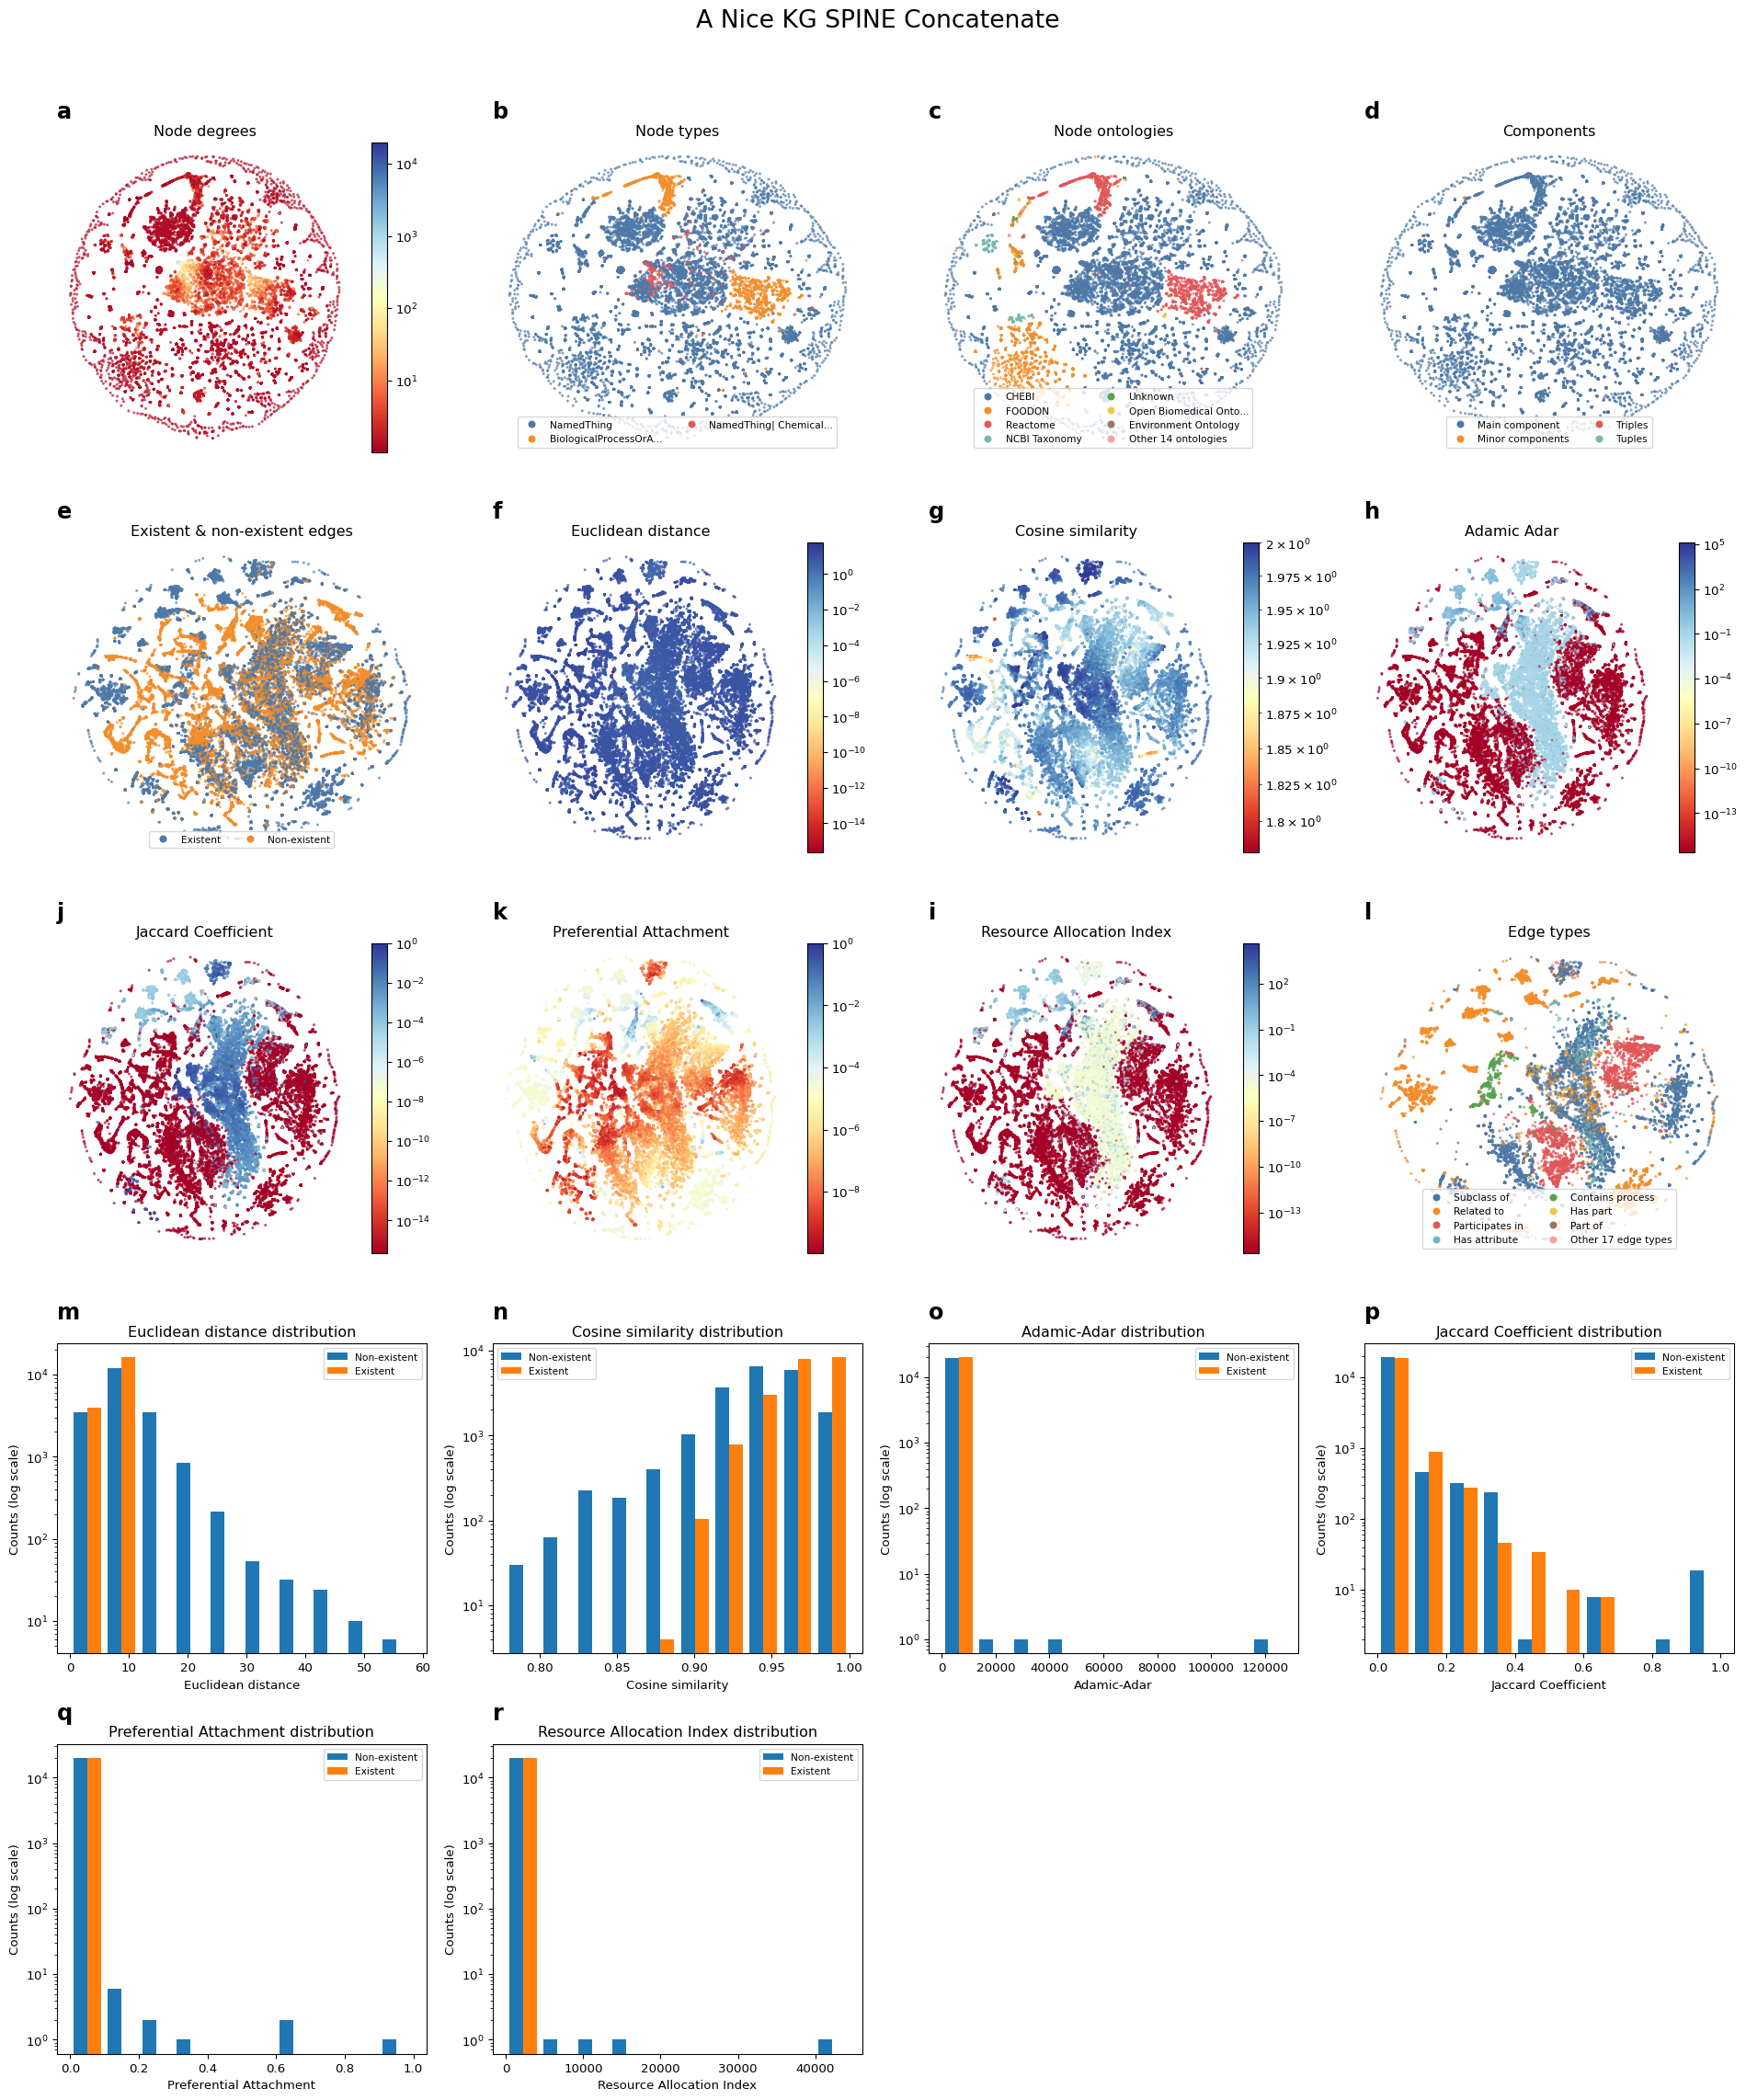

In [13]:
visualizer.fit_and_plot_all(embedding)

## Link Prediction

We may finally try to predict some new edges between foods and pathways. As we saw above, there are no paths directly between only these two types of nodes. Instead, we can attempt to find new potential relationships between all nodes in the graph.

At this point we'll just need to work with the largest fully connected component of the graph, as our methods won't work if all our nodes aren't connected to each other in some way. Let's see how many components are in the graph right now:

In [50]:
g.get_connected_components_number()

(14, 2, 232498)

The displayed triple tells us the total number of components, the size of the smallest component in nodes, and the size of the largest component in nodes, respectively. Most importantly, there's more than one component in there. Let's trim it down to just the component containing our pathway of interest.

In [52]:
trim_g = g.remove_components(node_names=['REACT:R-HSA-73894'])
trim_g.get_connected_components_number()

(1, 232498, 232498)

In [ ]:
trim_g.get_edge_prediction_subgraphs(number_of_nodes_to_sample=23000,
                                random_state=100,
                                node_sampling_method="random_nodes",
                                edge_weighting_methods=["unweighted_shortest_path","jaccard_coefficient"])